# This script is for plotting and analyzing maccor data for ICI testing

## How do I grab the ICI data?

### First Time Setup
Due to the number of decimal points needed for the analysis, you have to grab the data by hand (this may change in the future)

You will need **ViewData** on your PC. Go to the start menu on your PC and search for an application called **Run**, it should look something like this when you open it:

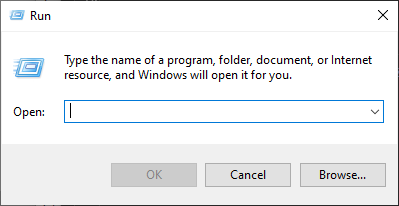

Now in the **Open:** prompt, put in **\\us-wal-bat-web1\BTD\Install\UserMaccorSoftware\Install.bat** and hit enter. A window will appear that looks like its running a lot of code, let it go until its all done and you find that there are desktop icons added that look like this:

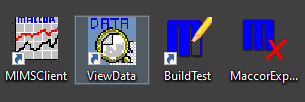

ViewData is the one we want for our needs. **We will need to modify the format of our data output first!** So open **ViewData**, it will open a window to get a file, in the area for the filepath, put in **\\us-wal-bat-mim1\Data\Backup**

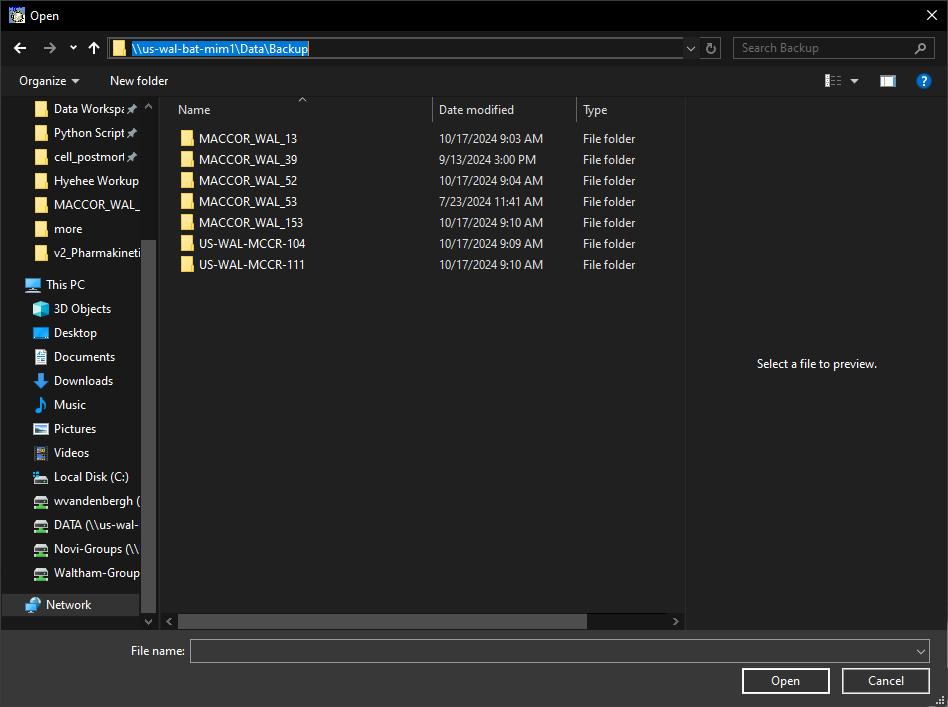

For the formating, grab any file from any maccor it doesn't matter. In **ViewData**, go to **Data** then **Options**

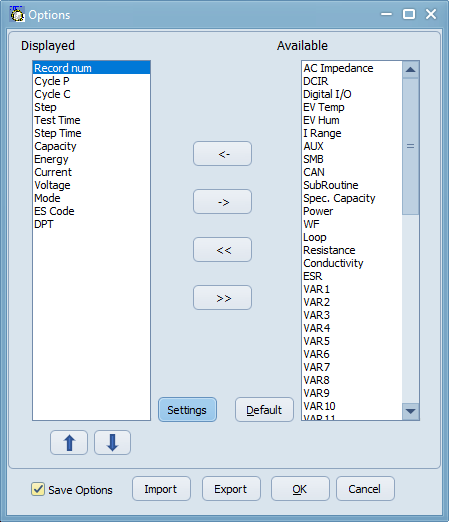

The format should have these critical entries, you may need to change both the Label and Format:

| Data Name | Label | Format | Units |
| --- | --- | --- | --- |
| Record Num | Rec# | #,##0 | N/A |
| Cycle P | Cycle P | #,##0 | N/A |
| Cycle C | Cycle C | #,##0 | N/A |
| Step | Step | #,##0 | N/A |
| Test Time | Test Time | #,##0.## | Standard |
| Step Time | Step Time | N/A | Standard |
| Capacity | Capacity (mAHr) | #,##0.###### | mAHr |
| Energy | Energy (WHr) | #,##0.###### | Watt-Hour |
| Current | Current (mA) | #,##0.###### | mA |
| Voltage | Voltage (V) | #,##0.###### | Volts |
| Mode | MD | N/A | N/A |
| ES Code | ES | N/A | N/A |
| DPT | DPT | N/A | Standard |


Be sure to check the **Save Options** box once you're done, this will save you from doing this over again.


### Data Extraction

Step 1: Open **ViewData** and get your data from **\\us-wal-bat-mim1\Data\Backup**

Step 2: Once the data loads, then go to **File** --> **Save As...** and save the data in the folder you will work in with this script. Be sure that the format has been arranged correctly and that it is saved as a .txt file

Step 3: Repeat for all your data files


## How do I use this script? I don't know any coding...

No problem, if you can hit Shift+Enter and type into prompts then you are fine.

### Step 1

You should see a blue bar to the left of this text, this refers to which part of the code the system will read next. To have the system read the code, just hit Shift+Enter and it will go to the next "Cell"

### Step 2

Each cell will have a Blurb at the top with a # before it, this is meant to tell you what the cell is doing. There are some cells that you don't need to worry about changing and others that only need very minor input.

Read the blurb, if it says "#Don't worry about it", then just hit Shift+Enter

You can tell if the cell is done running by either an output such as a number or plot OR it will read "DONE"


In [ ]:
#Details
#Package Req: Combat Cocktail
#Last edited: 30 - 10 - 24
#Author: Wess van den Bergh

#Don"t worry about it, just hit Shift+Enter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.colors as pc
import cmcrameri as cmc
import warnings
import os
import sys
from tkinter import*
import pickle
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import clear_output
from scipy.interpolate import griddata


def import_teamed_maccor_data():
    """
    grabs the necessary maccor files either from the ASCII server or the txt files
    Also asks user for mass values and how things are grouped
    """
    
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call("wm", "attributes", ".", "-topmost", True)
        
    from tkinter import filedialog
    infiles = filedialog.askopenfilename(multiple=True, initialdir = r'\\us-wal-bat-mim1\Data\ASCIIfiles')
    
    %gui tk
    
    custom_labels = pd.DataFrame(columns = ['filepath', 'label', 'team'])
    custom_labels = pd.concat([custom_labels, pd.DataFrame([{} for _ in range(len(infiles))])], ignore_index=True)

    for i,path in enumerate(infiles): 
        custom_labels.loc[i, 'filepath'] = path
        filename = os.path.basename(path)
        custom_labels.loc[i, 'label'] = str(input("Enter a label for {}: ".format(filename)))
        custom_labels.loc[i, 'mass'] = float(input("What is the mass of {} in mg? ".format(filename)))
        
        if len(infiles) != 1:
            custom_labels.loc[i, 'team'] = (input("GROUP/CONDITION name for {} -- ENSURE THE NAMES MATCH: ".format(custom_labels.iloc[i]['label'])))
        else:
             custom_labels.loc[i, 'team'] = custom_labels.loc[i, 'label']
    
    print(custom_labels)
    return custom_labels


def find_maccor_header_txt(file_path):
    """
    opens the file and checks the first ten rows to see where the headers and data really begins, 
    this makes it agnostic to the source of the data
    """
    with open(file_path, 'r') as file:
        rows = []
        for i in range(10):
            line = file.readline()
            if not line:
                raise("End of file and header not found")
            if 'Rec#\tCycle P\t' in line:
                return i #row number to start at for the headers
            if i == 10:
                raise("Checked first ten rows, no header found")

def analyze_ici(
    custom_labels,
    ici_interval_seconds,
    rest_time_seconds,
    rest_time_recording_interval,
    model_time_window,
    diffusion_pathlength_microns,
    ici_voltage_window = [3.0, 4.3]
    ):
    
    """
    takes imported maccor data and runs analysis on the ICI process
    """
    
    # ici_interval_seconds = 3600
    # rest_time_seconds = 10
    # rest_time_recording_interval = 0.1
    # model_time_window = [1, 5]
    # diffusion_pathlength_microns = 0.8
    
    AX_FONT_SIZE = 14
    POINT_SIZE = 7
    LINE_WIDTH = 2
    
    warnings.filterwarnings("ignore")
    
    for cell in range(len(custom_labels)):
    
        ici_data_dict = {"id" : custom_labels.iloc[cell]["label"]} #put in ID of sample

        maccor_header_line_number = find_maccor_header_txt(custom_labels.iloc[cell]["filepath"])

        # if custom_labels.iloc[cell]["fileform"] == "ascii":
        temp_data = pd.read_csv(custom_labels.iloc[cell]["filepath"], sep = "\t", skiprows = maccor_header_line_number, header = 0)
            
        # else:
            # temp_data = pd.read_csv(custom_labels.iloc[cell]["filepath"], sep = "\t", skiprows = maccor_header_line_number, header = 0)

        for cycle_number in range(1, temp_data["Cycle P"].max()+1): #Number of cycles it has to go through, skipping the rest step, +1 is for the last cycle because 0-indexing is goofy
            temp_data_cycle = temp_data[(temp_data["Cycle P"] == cycle_number)] # creates a df for each cycle, starting with 1

            #preallocate dataframes for the two value sets of interest
            diffusivity_df = pd.DataFrame({
                "voltage": [],
                "mode" : [],
                "delta_eoc_delta_ti": [],
                "dedt_slope" : [],
                "intercept" : [],
                "rsquare" : [],
                "diffusivity": []
            })

            resistance_df = pd.DataFrame({
                "voltage": [],
                "mode": [],
                "diffusion_resistance_slope" : [],
                "internal_resistance_intercept" : [],
                "rsquare" : []
            })

            temp_charge_cap = float("nan")
            temp_discharge_cap = float("nan")

            temp_data_cycle["Test Time"] = pd.to_timedelta(temp_data_cycle["Test Time"])
            temp_data_cycle["Test Time"] = temp_data_cycle["Test Time"].dt.total_seconds() / 3600
            fig1, ax1 = plt.subplots(figsize = (8,6))
            plot = ax1.plot(temp_data_cycle["Test Time"], temp_data_cycle["Voltage (V)"],
                            marker = ".", markersize = POINT_SIZE, lw = LINE_WIDTH)

            plt.xlabel("Time (Hr)",  fontsize = AX_FONT_SIZE, fontweight = "bold")
            plt.ylabel("Voltage (V)",  fontsize = AX_FONT_SIZE, fontweight = "bold")
            plt.xticks(fontsize=AX_FONT_SIZE, fontweight="bold")
            plt.yticks(fontsize=AX_FONT_SIZE, fontweight="bold")

            plt.show()

            user_check_cycle_cycle_quality = input("Is this cycle okay? (y/n) ")

            plt.clf
            clear_output()

            if user_check_cycle_cycle_quality.lower() in ["true", "1", "t", "y", "yes"]:

                #getting diffusivity

                    # getting D_Eoc/D_tI
                temp_data_cycle_pseudo_ocv = temp_data_cycle[
                (temp_data_cycle["ES"] == 0) & (temp_data_cycle["MD"] == "R") &
                (temp_data_cycle["Voltage (V)"] > ici_voltage_window[0]) &
                (temp_data_cycle["Voltage (V)"] < ici_voltage_window[1])
                ]

                delta_e = temp_data_cycle_pseudo_ocv["Voltage (V)"].diff()
                delta_e.iloc[-1] = np.nan #removes the rest steps
                delta_e_over_delta_t = delta_e / ici_interval_seconds

                diffusivity_df["delta_eoc_delta_ti"] = np.array(delta_e_over_delta_t)

                    # getting dE/dsqrt(t) -- selects for entries that are actual cycle values, are rest steps, and are inside the ICI window of interest
                temp_data_cycle_interrupts = temp_data_cycle[
                (temp_data_cycle["ES"] == 1) | (temp_data_cycle["ES"] == 0) & 
                (temp_data_cycle["MD"] == "R") &
                (temp_data_cycle["Voltage (V)"] > ici_voltage_window[0]) &
                (temp_data_cycle["Voltage (V)"] < ici_voltage_window[1]) 
                ]

                temp_data_cycle_interrupts["Rec#"] = temp_data_cycle_interrupts["Rec#"].str.replace(",", "").astype(int)

                    #splitting up the interrupts based on discontinuities of the recording number
                discontinuities = temp_data_cycle_interrupts["Rec#"].diff() != 1
                discontinuity_indices = discontinuities[discontinuities].index

                temp_data_cycle_interrupts_list = []
                for end_idx in discontinuity_indices:
                    temp_data_cycle_interrupts_list.append(temp_data_cycle_interrupts.loc[end_idx : end_idx+(int(rest_time_seconds / rest_time_recording_interval) - 1)]) #minus 1 due to index quirks

                for ici_interrupt_number in range(len(temp_data_cycle_interrupts_list) - 1): #minus 1 because the initial rest step is included in the filtering above
                    temp_ici_interrupt_df = temp_data_cycle_interrupts_list[ici_interrupt_number]
                    temp_ici_interrupt_df["sqrt_seconds"] = np.sqrt(
                        (pd.to_timedelta(temp_ici_interrupt_df["Step Time"])
                         .dt.total_seconds().astype(float))
                    )

                    #getting the time range that is linear for the model
                    temp_ici_interrupt_df_for_model = temp_ici_interrupt_df[
                    (temp_ici_interrupt_df["sqrt_seconds"] >= np.sqrt(model_time_window[0])) & 
                    (temp_ici_interrupt_df["sqrt_seconds"] <= np.sqrt(model_time_window[1]))
                    ]

                    try:
                        temp_model = LinearRegression()
                        temp_model.fit(temp_ici_interrupt_df_for_model[["sqrt_seconds"]], temp_ici_interrupt_df_for_model[["Voltage (V)"]])
                    except ValueError: #just in case a rest is still included
                        print("Hit a rest step that was not an interrupt")
                        break

                    if temp_model.coef_[0] > 0:
                        mode = "D"
                    elif temp_model.coef_[0] < 0:
                        mode = "C"

                    diffusivity_df.loc[ici_interrupt_number, "voltage"] = temp_ici_interrupt_df_for_model["Voltage (V)"].iloc[0]
                    diffusivity_df.loc[ici_interrupt_number, "mode"] = mode
                    diffusivity_df.loc[ici_interrupt_number, "dedt_slope"] = temp_model.coef_[0]
                    diffusivity_df.loc[ici_interrupt_number, "intercept"] = temp_model.intercept_
                    diffusivity_df.loc[ici_interrupt_number, "rsquare"] = temp_model.score(temp_ici_interrupt_df_for_model[["sqrt_seconds"]], temp_ici_interrupt_df_for_model[["Voltage (V)"]])

                # getting diffusivity values
                diffusivity_df["diffusivity"] = (4 / np.pi) * np.square(
                    (diffusion_pathlength_microns / 10000) * ( #converting microns to cm
                        np.array(delta_e_over_delta_t) / np.array(diffusivity_df["dedt_slope"])
                    )
                )

                    #getting internal resistance
                # E(DELTA t) - E_before_interrupt = -IR - Ik*sqrt(DELTA t)
                temp_data_cycle_e_before_interrupt = temp_data_cycle[
                    (temp_data_cycle["ES"] == 129) & (temp_data_cycle["MD"] == "C") &
                    (temp_data_cycle["Voltage (V)"] > ici_voltage_window[0]) & 
                    (temp_data_cycle["Voltage (V)"] < ici_voltage_window[1])|
                    (temp_data_cycle["ES"] == 129) & (temp_data_cycle["MD"] == "D") &
                    (temp_data_cycle["Voltage (V)"] > ici_voltage_window[0]) &
                    (temp_data_cycle["Voltage (V)"] < ici_voltage_window[1])
                    ]

                temp_data_cycle_e_before_interrupt["Rec#"] = temp_data_cycle_e_before_interrupt["Rec#"].str.replace(",", "").astype(int)

                resistance_loop_i = 0
                while resistance_loop_i != len(temp_data_cycle_e_before_interrupt):
                    if temp_data_cycle_interrupts_list[resistance_loop_i]["Rec#"].iloc[0] - temp_data_cycle_e_before_interrupt["Rec#"].iloc[resistance_loop_i] == 1: #used to check if the interrupt and the (dis)charge process are tied to one another

                        temp_ici_resistance_df = temp_data_cycle_interrupts_list[resistance_loop_i]
                        temp_ici_resistance_df["sqrt_seconds"] = np.sqrt(
                            (pd.to_timedelta(temp_ici_resistance_df["Step Time"])
                             .dt.total_seconds().astype(float))
                        )

                        #getting the time range that is linear for the model
                        temp_ici_resistance_df_for_model = temp_ici_resistance_df[
                        (temp_ici_resistance_df["sqrt_seconds"] >= np.sqrt(model_time_window[0])) & 
                        (temp_ici_resistance_df["sqrt_seconds"] <= np.sqrt(model_time_window[1]))
                        ]

                        de_parenth_dt = temp_ici_resistance_df_for_model["Voltage (V)"] - temp_data_cycle_e_before_interrupt["Voltage (V)"].iloc[resistance_loop_i]

                        resistance_model = LinearRegression()
                        resistance_model.fit(temp_ici_resistance_df_for_model[["sqrt_seconds"]], de_parenth_dt)

                        resistance_df.loc[resistance_loop_i, "voltage"] = temp_ici_resistance_df_for_model["Voltage (V)"].iloc[0]
                        resistance_df.loc[resistance_loop_i, "mode"] = temp_data_cycle_e_before_interrupt["MD"].iloc[resistance_loop_i]
                        resistance_df.loc[resistance_loop_i, "diffusion_resistance_slope"] = resistance_model.coef_[0] / (temp_data_cycle_e_before_interrupt["Current (mA)"].iloc[resistance_loop_i] / 1000)
                        resistance_df.loc[resistance_loop_i, "internal_resistance_intercept"] = resistance_model.intercept_ / (temp_data_cycle_e_before_interrupt["Current (mA)"].iloc[resistance_loop_i] / 1000)
                        resistance_df.loc[resistance_loop_i, "rsquare"] = resistance_model.score(temp_ici_resistance_df_for_model[["sqrt_seconds"]], de_parenth_dt)

                        resistance_loop_i += 1
                    elif temp_data_cycle_interrupts_list[resistance_loop_i]["Rec#"].iloc[0] - temp_data_cycle_e_before_interrupt["Rec#"].iloc[resistance_loop_i] != 1: #if there is a discontinuity between the two dataframes then remove the entry and re-run the loop
                        del temp_data_cycle_interrupts_list[resistance_loop_i]

            #getting capacity

                temp_data_cycle_ch = temp_data_cycle[
                (temp_data_cycle["MD"] == "C") &
                (temp_data_cycle["ES"] == 129) |
                (temp_data_cycle["MD"] == "C") &
                (temp_data_cycle["ES"] == 133)
                ]
                temp_charge_cap = temp_data_cycle_ch["Capacity (mAHr)"].sum(skipna=True) / (custom_labels.iloc[cell]["mass"] / 1000)

                temp_data_cycle_dis = temp_data_cycle[
                (temp_data_cycle["MD"] == "D") &
                (temp_data_cycle["ES"] == 129) |
                (temp_data_cycle["MD"] == "D") &
                (temp_data_cycle["ES"] == 133)
                ]
                temp_discharge_cap = temp_data_cycle_dis["Capacity (mAHr)"].sum(skipna=True) / (custom_labels.iloc[cell]["mass"] / 1000)

            cycle_dict = {
                "cycle_number" : cycle_number,
                "diffusivity_df" : diffusivity_df,
                "resistance_df" : resistance_df,
                "diffusivity_plot" : "NA",
                "resistance_plot" : "NA",
                "capacities_array" : [temp_charge_cap, temp_discharge_cap]
            }

            ici_data_dict[cycle_number] = cycle_dict

        with open(f"{custom_labels.iloc[cell]['label']}.pkl", "wb") as file:
            pickle.dump(ici_data_dict, file)

        print(f"Saved as {custom_labels.iloc[cell]['label']}.pkl in {os.getcwd()}")

    
def import_an_ici_pickle():
    """
    grabs a saved .pkl file of the ici data and imports it for 3D plotting and analysis
    """
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call("wm", "attributes", ".", "-topmost", True)
    
    from tkinter import filedialog
    infiles = filedialog.askopenfilename(multiple=False)
    
    %gui tk
    
    with open(infiles, "rb") as file:
        loaded_dict = pickle.load(file)
    return loaded_dict
    
    
def import_ici_pickles():
    """
    grabs a saved .pkl file of the ici data and imports it for 3D plotting and analysis
    """
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call("wm", "attributes", ".", "-topmost", True)
    
    from tkinter import filedialog
    infiles = filedialog.askopenfilename(multiple=True)
    
    %gui tk
    
    custom_labels = pd.DataFrame(columns = ['filepath', 'team'])
    custom_labels = pd.concat([custom_labels, pd.DataFrame([{} for _ in range(len(infiles))])], ignore_index=True)

    for i,filepath in enumerate(infiles):
        custom_labels.loc[i, 'filepath'] = filepath
        custom_labels.loc[i, 'team'] = (input(f"GROUP/CONDITION name for {os.path.basename(filepath)} -- ENSURE THE NAMES MATCH: "))
    
    print(custom_labels) 
    return custom_labels  
    

def plot_interactive_surface_plot(metric = "diffusivity", mode = "C"):
    
    """
    prepares a 3D plot from the ici data for resistance and diffusivity for both charge and discharge
    """
    
    loaded_dict = import_an_ici_pickle()
    
    if metric == "resistance":
        for key, value in loaded_dict.items():
            if 'resistance_df' in value and isinstance(value['resistance_df'], pd.DataFrame):
                df = value['resistance_df']
                if 'internal_resistance_intercept' in df.columns:
                    df.rename(columns={'internal_resistance_intercept': 'resistance'}, inplace=True)
    
    SIGN_FLIP = -1
    
    master_df = pd.DataFrame({
                "cycle": [],
                "voltage": [],
                f"{metric}": []
        })
    
    for i in range(1, len(loaded_dict)):
        temp_df = loaded_dict[i][f"{metric}_df"][(loaded_dict[i][f"{metric}_df"]["mode"] == mode)]
        temp_df = temp_df[["voltage",f"{metric}"]]
        temp_df["cycle"] = loaded_dict[i]["cycle_number"]

        master_df = pd.concat([master_df, temp_df], ignore_index = True)       
    
    master_df = master_df.dropna()
    
    #plot charge diffusivity
    xi = np.linspace(master_df["voltage"].min(), master_df["voltage"].max(), len(master_df["voltage"]))
    yi = np.linspace(master_df["cycle"].min(), master_df["cycle"].max(), len(master_df["cycle"]))
    xi2, yi2 = np.meshgrid(xi, yi)
    zi = griddata((master_df["voltage"], master_df["cycle"]), master_df[f"{metric}"], (xi2, yi2), method="linear")

    # Choose a cmcrameri colormap
    cmap = cmc.cm.hawaii

    # Convert the colormap to Plotly format
    cmap_colors = [pc.label_rgb(c) for c in cmap(np.linspace(0, 1, cmap.N))]
    
    # Update the layout
    if metric == "diffusivity":
        fig = go.Figure(data=[go.Surface(z=zi, x=xi2, y=yi2, 
                                         colorscale = cmap_colors, 
                                         colorbar = dict(tickformat = ".1e"),
                                         contours={
                                             "x": {"show": True, "color": "black", "width": 1},
                                             "y": {"show": True, "color": "black", "width": 1}
    })])
        
        fig.update_layout(
        title=f"ICI {metric} {mode}",
        scene=dict(
            xaxis_title="Voltage (V)",
            yaxis_title="Cycle",
            zaxis_title="Diffusivity (cm<sup>2</sup> s<sup>-1</sup>)",
            zaxis = dict(tickformat = ".1e", nticks = 10),
            xaxis = dict(nticks = 10),
            yaxis = dict(nticks = 10)
        ),
        autosize=False,
        width=800, height=600
        )
        
    elif metric == "resistance":
        if mode == "C":
            fig = go.Figure(data=[go.Surface(z=SIGN_FLIP*(zi), x=xi2, y=yi2, 
                                             colorscale = cmap_colors, 
                                             contours={
                                                 "x": {"show": True, "color": "black", "width": 1},
                                                 "y": {"show": True, "color": "black", "width": 1}
                                             })])
        elif mode == "D":
               fig = go.Figure(data=[go.Surface(z=zi, x=xi2, y=yi2, 
                                         colorscale = cmap_colors, 
                                         contours={
                                             "x": {"show": True, "color": "black", "width": 1},
                                             "y": {"show": True, "color": "black", "width": 1}
                                         })])
        
        fig.update_layout(
        title=f"ICI {metric} {mode}",
        scene=dict(
            xaxis_title="Voltage (V)",
            yaxis_title="Cycle",
            zaxis_title="Resistance (Ohms)",
            zaxis = dict(nticks = 10),
            xaxis = dict(nticks = 10),
            yaxis = dict(nticks = 10)
        ),
        autosize=False,
        width=800, height=600
        )
    
    fig.show()


def get_ici_stats(save_compiled_data_as_csv = True,
                  plot_capacity = True,
                  plot_median_resistance = True,
                  plot_median_diffusion = True,
                  add_chargevals_to_plot = True, 
                  line_width = 2, 
                  point_size = 7, 
                  ax_font_size = 14, 
                  capacity_ylims = [0, 250], 
                  resistance_ylims = [0,200],
                  diffusion_ylims = []):

    # warnings.filterwarnings("ignore")
    
    custom_labels = import_ici_pickles()
    custom_labels_sorted = custom_labels.sort_values(by = 'team')
    unique_teams = custom_labels_sorted['team'].unique()

    if plot_capacity == True:
        fig_capacity, ax_capacity = plt.subplots(figsize = (8,6))

    if plot_median_resistance == True:
        SIGN_FLIP_FOR_CH_RESISTANCE = -1
        fig_resistance, ax_resistance = plt.subplots(figsize = (8,6))

    if plot_median_diffusion == True:
        fig_diffusion, ax_diffusion = plt.subplots(figsize = (8,6))
    
    for team in unique_teams:
        forloop_group = custom_labels_sorted[custom_labels_sorted['team'] == team]
        
        try:
            del temp_team_dataframe, temp_team_grouped_stats, temp_dataframe
            
        except UnboundLocalError:
            pass
        
        for cell_num in range(len(forloop_group)):
            with open(forloop_group.iloc[cell_num]['filepath'], "rb") as file:
                temp_cell = pickle.load(file)
            
            try: 
                del temp_dataframe, temp_row #deleting last temp variables to prevent issues with doubling up analysis/plotting
            except UnboundLocalError:
                pass

            for cycle in range(1,len(temp_cell)):
                temp_row = {'cycle' : cycle,
                            'charge_cap' : temp_cell[cycle]['capacities_array'][0],
                            'discharge_cap' : temp_cell[cycle]['capacities_array'][1]       
                }
            
                if temp_cell[cycle]['resistance_df'].size > 0:
                    temp_diff_stats = temp_cell[cycle]['diffusivity_df'].groupby('mode').describe()["diffusivity"]
                    temp_resistance_stats = temp_cell[cycle]['resistance_df'].groupby('mode').describe()['internal_resistance_intercept']
                
                            
                    try:
                        temp_row.update({
                                    'resistance_mean_ch' : temp_resistance_stats["mean"].iloc[0],
                                    'resistance_median_ch': temp_resistance_stats["50%"].iloc[0],
                                    #'r_std_ch': temp_resistance_stats["std"][0],
                                    'diffusion_mean_ch': temp_diff_stats["mean"].iloc[0],
                                    'diffusion_median_ch': temp_diff_stats["50%"].iloc[0],
                                    # 'diff_std_ch': temp_diff_stats["std"][0],
            
                        })
                    except IndexError:
                        temp_row.update({
                                'resistance_mean_ch' : np.nan,
                                'resistance_median_ch': np.nan,
                                #'r_std_ch': temp_resistance_stats["std"][0],
                                'diffusion_mean_ch': np.nan,
                                'diffusion_median_ch': np.nan
                                #'diff_std_ch': temp_diff_stats["std"][0],
                            })
            
                    try:
                        temp_row.update({
                                    'resistance_mean_dis' : temp_resistance_stats["mean"].iloc[1],
                                    'resistance_median_dis': temp_resistance_stats["50%"].iloc[1],
                                    #'r_std_dis': temp_resistance_stats["std"][1],
                                    'diffusion_mean_dis': temp_diff_stats["mean"].iloc[1],
                                    'diffusion_median_dis': temp_diff_stats["50%"].iloc[1]
                                    #'diff_std_dis': temp_diff_stats["std"][1]
                        })
            
            
                    except IndexError:
                        temp_row.update({
                                'resistance_mean_dis' : np.nan,
                                'resistance_median_dis': np.nan,
                                #'r_std_ch': temp_resistance_stats["std"][0],
                                'diffusion_mean_dis': np.nan,
                                'diffusion_median_dis': np.nan
                                #'diff_std_ch': temp_diff_stats["std"][0],
                            })
            
                try:
                    temp_dataframe = pd.concat([temp_dataframe, pd.DataFrame(data=temp_row, index = [0])], ignore_index = True)
                except NameError:
                    temp_dataframe = pd.DataFrame(data=temp_row, index = [0])

            try:
                temp_team_dataframe = pd.concat([temp_team_dataframe, temp_dataframe], ignore_index = True)
            except NameError:
                temp_team_dataframe = temp_dataframe
                
#         #plot the data
        temp_team_grouped_stats = temp_team_dataframe.groupby('cycle').describe().dropna(thresh = 3)
        if save_compiled_data_as_csv == True:
            temp_team_grouped_stats.to_csv('{csvlabel}.csv'.format(csvlabel = team))

        # return temp_team_grouped_stats
        
        if plot_capacity == True:
            # fig_capacity, ax_capacity = plt.subplots(figsize = (8,6))
            ax_capacity.errorbar(x = temp_team_grouped_stats['discharge_cap']['mean'].index,
                     y = temp_team_grouped_stats['discharge_cap']['mean'],
                     yerr = temp_team_grouped_stats['discharge_cap']['std'] / np.sqrt(temp_team_grouped_stats['discharge_cap']['count']),
                     marker = 'v', markersize = point_size, lw = line_width,
                     elinewidth = line_width/2, capsize = line_width/1.2,
                     c = cmc.cm.bukavu(((np.where(unique_teams == team)[0][0])/len(unique_teams))*0.4),
                    )
            if add_chargevals_to_plot == True:
                ax_capacity.errorbar(x = temp_team_grouped_stats['charge_cap']['mean'].index,
                         y = temp_team_grouped_stats['charge_cap']['mean'],
                         yerr = temp_team_grouped_stats['charge_cap']['std'] / np.sqrt(temp_team_grouped_stats['charge_cap']['count']),
                         marker = '^', markersize = point_size, lw = line_width,
                         elinewidth = line_width/2, capsize = line_width/1.2,
                         c = cmc.cm.bukavu((((np.where(unique_teams == team)[0][0])/len(unique_teams))*0.4)+0.5)
                        )

            ax_capacity.set_xlabel('Cycle', fontsize=ax_font_size, fontweight='bold')
            ax_capacity.set_ylabel(r'Avg. Capacity (mAh g$^{-1}$)', fontsize=ax_font_size, fontweight='bold')
            ax_capacity.tick_params(axis='both', direction='in', length=10, labelsize=ax_font_size)  # Set the length of tick marks
            
            # Set the line width for each spine
            ax_capacity.spines['top'].set_linewidth(4)
            ax_capacity.spines['bottom'].set_linewidth(4)
            ax_capacity.spines['left'].set_linewidth(4)
            ax_capacity.spines['right'].set_linewidth(4)


            if add_chargevals_to_plot == True:
                legend_labels_capacity = []
                for string in unique_teams:
                    legend_labels_capacity.append(string + '_dis')
                    legend_labels_capacity.append(string + '_ch')
            else:
                legend_labels_capacity = []
                for string in unique_teams:
                    legend_labels.append(string + '_dis')
        
            legend_capacity = ax_capacity.legend(legend_labels_capacity, framealpha=1, frameon=True, fontsize=ax_font_size - 4, loc="lower left")
            frame_capacity = legend_capacity.get_frame()
            frame_capacity.set_edgecolor('black')  # Set legend box color
            frame_capacity.set_linewidth(2)        # Set legend box thickness
            for text_capacity in legend_capacity.get_texts():
                text_capacity.set_fontweight('bold')

            if capacity_ylims:
                ax_capacity.set_ylim(capacity_ylims) 


                  #         capacity_ylims = [0, 250], 
                  # resistance_ylims = [0,200]
                  # diffusion_ylims = [])
####################
        
        if plot_median_resistance == True:
            # SIGN_FLIP_FOR_CH_RESISTANCE = -1
            # fig_resistance, ax_resistance = plt.subplots(figsize = (8,6))
            ax_resistance.errorbar(x = temp_team_grouped_stats['resistance_median_dis']['mean'].index,
                     y = temp_team_grouped_stats['resistance_median_dis']['mean'],
                     yerr = temp_team_grouped_stats['resistance_median_dis']['std'] / np.sqrt(temp_team_grouped_stats['resistance_median_dis']['count']),
                     marker = 'v', markersize = point_size, lw = line_width,
                     elinewidth = line_width/2, capsize = line_width/1.2,
                     c = cmc.cm.bukavu(((np.where(unique_teams == team)[0][0])/len(unique_teams))*0.4),
                    )
            if add_chargevals_to_plot == True:
                ax_resistance.errorbar(x = temp_team_grouped_stats['resistance_median_ch']['mean'].index,
                         y = SIGN_FLIP_FOR_CH_RESISTANCE * temp_team_grouped_stats['resistance_median_ch']['mean'],
                         yerr = temp_team_grouped_stats['resistance_median_ch']['std'] / np.sqrt(temp_team_grouped_stats['resistance_median_ch']['count']),
                         marker = '^', markersize = point_size, lw = line_width,
                         elinewidth = line_width/2, capsize = line_width/1.2,
                         c = cmc.cm.bukavu((((np.where(unique_teams == team)[0][0])/len(unique_teams))*0.4)+0.5)
                        )

            ax_resistance.set_xlabel('Cycle', fontsize=ax_font_size, fontweight='bold')
            ax_resistance.set_ylabel('Avg. of Median Cell Resistance (Ohms)', fontsize=ax_font_size, fontweight='bold')
            ax_resistance.tick_params(axis='both', direction='in', length=10, labelsize=ax_font_size)  # Set the length of tick marks
            
            # Set the line width for each spine
            ax_resistance.spines['top'].set_linewidth(4)
            ax_resistance.spines['bottom'].set_linewidth(4)
            ax_resistance.spines['left'].set_linewidth(4)
            ax_resistance.spines['right'].set_linewidth(4)


            if add_chargevals_to_plot == True:
                legend_labels_resistance = []
                for string in unique_teams:
                    legend_labels_resistance.append(string + '_dis')
                    legend_labels_resistance.append(string + '_ch')
            else:
                legend_labels_resistance = []
                for string in unique_teams:
                    legend_labels.append(string + '_dis')
        
            legend_resistance = ax_resistance.legend(legend_labels_resistance, framealpha=1, frameon=True, fontsize=ax_font_size - 4, loc="lower left")
            frame_resistance = legend_resistance.get_frame()
            frame_resistance.set_edgecolor('black')  # Set legend box color
            frame_resistance.set_linewidth(2)        # Set legend box thickness
            for text_resistance in legend_resistance.get_texts():
                text_resistance.set_fontweight('bold')

            if resistance_ylims:
                ax_resistance.set_ylim(resistance_ylims) 


####################

        
        if plot_median_diffusion == True:
            # fig_diffusion, ax_diffusion = plt.subplots(figsize = (8,6))
            ax_diffusion.errorbar(x = temp_team_grouped_stats['diffusion_median_dis']['mean'].index,
                     y = temp_team_grouped_stats['diffusion_median_dis']['mean'],
                     yerr = temp_team_grouped_stats['diffusion_median_dis']['std'] / np.sqrt(temp_team_grouped_stats['diffusion_median_dis']['count']),
                     marker = 'v', markersize = point_size, lw = line_width,
                     elinewidth = line_width/2, capsize = line_width/1.2,
                     c = cmc.cm.bukavu(((np.where(unique_teams == team)[0][0])/len(unique_teams))*0.4),
                    )
            if add_chargevals_to_plot == True:
                ax_diffusion.errorbar(x = temp_team_grouped_stats['diffusion_median_ch']['mean'].index,
                         y = temp_team_grouped_stats['diffusion_median_ch']['mean'],
                         yerr = temp_team_grouped_stats['diffusion_median_ch']['std'] / np.sqrt(temp_team_grouped_stats['diffusion_median_ch']['count']),
                         marker = '^', markersize = point_size, lw = line_width,
                         elinewidth = line_width/2, capsize = line_width/1.2,
                         c = cmc.cm.bukavu((((np.where(unique_teams == team)[0][0])/len(unique_teams))*0.4)+0.5)
                        )

            ax_diffusion.set_xlabel('Cycle', fontsize=ax_font_size, fontweight='bold')
            ax_diffusion.set_ylabel(r'Avg. of Median Diffusion (cm$^{2}$ s$^{-1}$)', fontsize=ax_font_size, fontweight='bold')
            ax_diffusion.tick_params(axis='both', direction='in', length=10, labelsize=ax_font_size)  # Set the length of tick marks
            
            # Set the line width for each spine
            ax_diffusion.spines['top'].set_linewidth(4)
            ax_diffusion.spines['bottom'].set_linewidth(4)
            ax_diffusion.spines['left'].set_linewidth(4)
            ax_diffusion.spines['right'].set_linewidth(4)


            if add_chargevals_to_plot == True:
                legend_labels_diffusion = []
                for string in unique_teams:
                    legend_labels_diffusion.append(string + '_dis')
                    legend_labels_diffusion.append(string + '_ch')
            else:
                legend_labels_diffusion = []
                for string in unique_teams:
                    legend_labels.append(string + '_dis')
        
            legend_diffusion = ax_diffusion.legend(legend_labels_diffusion, framealpha=1, frameon=True, fontsize=ax_font_size - 4, loc="lower left")
            frame_diffusion = legend_diffusion.get_frame()
            frame_diffusion.set_edgecolor('black')  # Set legend box color
            frame_diffusion.set_linewidth(2)        # Set legend box thickness
            for text_diffusion in legend_diffusion.get_texts():
                text_diffusion.set_fontweight('bold')

            if diffusion_ylims:
                ax_diffusion.set_ylim(diffusion_ylims) 
        
print("DONE")    

In [ ]:
# hit Shift+Enter and grab the data you want to analyze
ici_maccor_data = import_teamed_maccor_data()

In [ ]:
# Check that the ici_interval_seconds value matches the intervals used in the maccor procedure,
# the same goes for rest time and interval although these should not be changed

analyze_ici(
    ici_maccor_data,
    ici_interval_seconds = 900, #NOTE this must be the same for all data used
    rest_time_seconds = 10, #typically dont need to change
    rest_time_recording_interval = 0.1, #typically dont need to change
    model_time_window = [1, 5], #typically dont need to change
    diffusion_pathlength_microns = 1.5, #should be ~1/2 of the particle diameter
    ici_voltage_window = [2.5, 4.3] #Enter the upper and lower cutoff values for the ICI window
)

    # ici_interval_seconds = 900
    # rest_time_seconds = 10
    # rest_time_recording_interval = 0.1
    # model_time_window = [1, 5]
    # diffusion_pathlength_microns = 0.8
    # ici_voltage_window = [3.0, 4.3]

In [ ]:
# Run this cell if you want the surface plots for "resistance" or "diffusivity" during charge "C" or discharge "D"

plot_interactive_surface_plot(metric = "resistance", mode = "C")

In [ ]:
# Run this cell if you want to get different plots of the data as a function of cycle
get_ici_stats(save_compiled_data_as_csv = False,
              plot_capacity = True,
              plot_median_resistance = True,
              plot_median_diffusion = True,
              add_chargevals_to_plot = True, 
              line_width = 2, 
              point_size = 7, 
              ax_font_size = 14,
              capacity_ylims = [0, 250], #leave empty [] if you want the program to set the limits for you
              resistance_ylims = [0,200], #leave empty [] if you want the program to set the limits for you
              diffusion_ylims = []) #leave empty [] if you want the program to set the limits for you, use 1e-X for limits